In [1]:
# Created on Monay 1 July 2019 by Claudio Bellani
# numerical experiments for my paper "Mechanics of good trade execution in the framework of linear temporary market impact"

In [2]:
import numpy as np

import pandas as pd

import datetime

import scipy

import pickle

from scipy.stats import norm as normalDistribution

from scipy.stats import expon as exponentialDistribution

from scipy.stats import pareto 

from scipy.stats import bernoulli

from scipy.stats import cauchy as cauchyDistribution

# from scipy.stats import t as tStudent

# from fbm import FBM

import matplotlib.pyplot as plt

# from matplotlib.colors import BoundaryNorm
# from matplotlib.ticker import MaxNLocator
# from sklearn.preprocessing import normalize

# from mpl_toolkits.mplot3d import Axes3D 

from termcolor import colored

# from scipy import optimize

from numpy.polynomial.polynomial import*

In [3]:
import times_

from times_ import randomSign

import gte

In [4]:
dateTime=datetime.datetime.now()

In [5]:
with open('param_gte_AAPL','rb') as source:
    param_AAPL=pickle.load(source)

In [6]:
initialInventory=100*param_AAPL['bidVolume'].max()
liquidationTarget=0.0
date='2019-01-31'
initialPrice=param_AAPL[param_AAPL.date==date].initial_price.values
stochastic_process='aBM'
volatility=param_AAPL['volatility'].max()
coeffMarketImpact=5.05e-01
coeffRiskAversion=9.50e-01

initialTime=0.0
timeHorizon=1.0
timeHorizon_price=2.0
numberOfPartitionPoints=50000



In [7]:
# with open('param_bridge_DE000','rb') as source:
#     param_DE000=pickle.load(source)

# param_DE000

,price_on_24/02/2017,avg,std,price_process,vol
DE0001141711,102.758,101.202385,0.774095,bridge,1.595738
DE0001141729,103.893,102.246960,0.830204,bridge,1.870230
DE0001141703,103.201,101.593300,0.806122,bridge,2.082362
DE0001141737,103.097,101.757502,0.505060,bridge,1.720306


In [56]:
# initialInventory=1.0e+05
# liquidationTarget=0.0
# # date='2019-01-31'
# initialPrice=param_DE000['price_on_24/02/2017'].max()
# stochastic_process='bridge'
# volatility=param_DE000['vol'].max()
# coeffMarketImpact=2.355e-02
# coeffRiskAversion=7.0410e-02

# initialTime=0.0
# timeHorizon=1.0
# timeHorizon_price=2.0
# numberOfPartitionPoints=10000


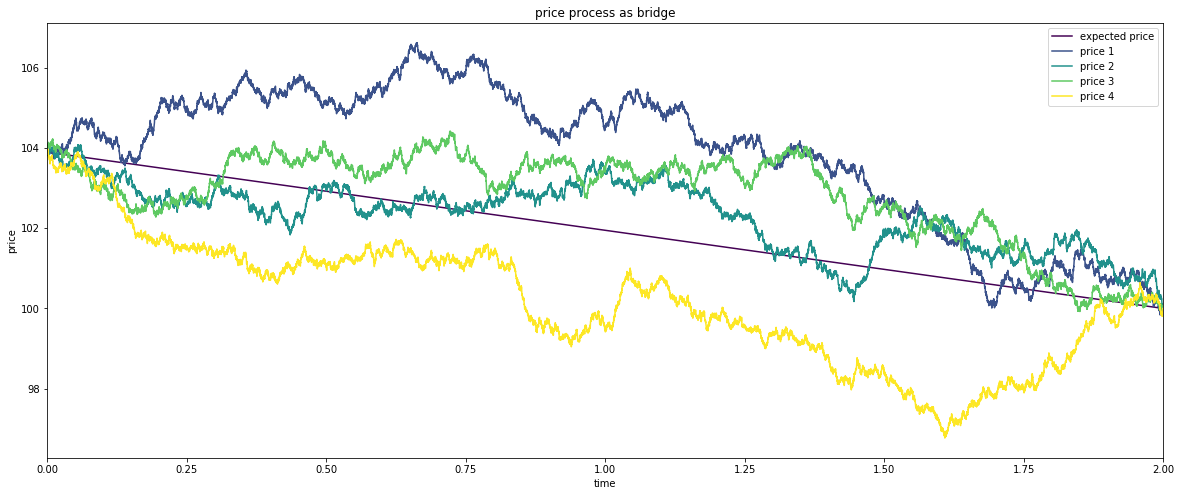

In [43]:
timeWindow_execution=np.linspace(initialTime,timeHorizon,num=numberOfPartitionPoints)
timeWindow_price,is_timeWindow_execution=times_.mergeGrids(timeWindow_execution,
                                   np.linspace(timeHorizon,timeHorizon_price,num=numberOfPartitionPoints))

priceProcess=gte.price(timeWindow_price,
                   initialPrice=initialPrice,
                   volatility=volatility,
                   stochastic_process=stochastic_process,
                   num_of_simulations=100,
                   plot_price=True)



In [10]:
# with open('aBM_{}d{}h{}m_priceProcess'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(priceProcess,outfile)

In [57]:
inventory_label=gte.produce_labelsForInventories(n=priceProcess.pricePaths.shape[1]-1)
termination_times=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
errorOfLiquidation=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
xi=pd.DataFrame(np.ones((1,priceProcess.pricePaths.shape[1])),
                       columns=inventory_label)
core_execution=pd.DataFrame(np.ones((timeWindow_execution.shape[0],priceProcess.pricePaths.shape[1])),
                       columns=inventory_label,
                       index=priceProcess.pricePaths.index[priceProcess.pricePaths.index<=timeHorizon])
trajectories=pd.DataFrame(np.zeros((timeWindow_execution.shape[0],1)),
                          index=priceProcess.pricePaths.index[priceProcess.pricePaths.index<=timeHorizon])

i=0
for col in priceProcess.pricePaths.columns:
    execution=gte.liquidation(priceProcess.pricePaths[col],
                          priceProcess.expectedPricePath,
                          initialInventory=initialInventory,
                          liquidationTarget=liquidationTarget,
                          coeffMarketImpact=coeffMarketImpact,
                          coeffRiskAversion=coeffRiskAversion,
                          initialTime=initialTime,
                          timeHorizon=timeHorizon,
                          method_extensionOfInventoryTrajectory='eulerLagrange')
#     print('is_StaticInPathwiseNeighbourhood={}'.format(execution.is_StaticInPathwiseNeighbourhood))
    termination_times.iloc[:,i]=execution.terminationTime
    errorOfLiquidation.iloc[:,i]=execution.errorOfLiquidation
    xi.iloc[:,i]=execution.xi
    trajectories=pd.concat([trajectories,execution.trajectory],axis=1,sort=False)
    core_execution.iloc[:,i]=execution.core_inventoryTrajectory
    i+=1



trajectories=trajectories.iloc[:,1:]
trajectories.columns=inventory_label

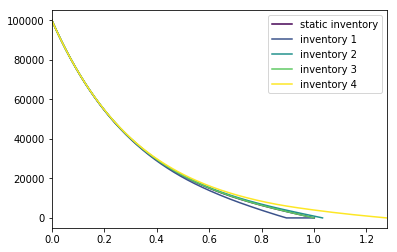

In [58]:
trajectories.plot(cmap='viridis')

In [13]:
def compute_termination(price_path):
    price_path=pd.Series(price_path,index=priceProcess.pricePaths.index)
    execution=gte.liquidation(price_path,                 
                              priceProcess.expectedPricePath, 
                              initialInventory=initialInventory,  
                              liquidationTarget=liquidationTarget,
                              coeffMarketImpact=coeffMarketImpact,    
                              coeffRiskAversion=coeffRiskAversion,   
                              initialTime=initialTime,               
                              timeHorizon=timeHorizon,              
                              method_extensionOfInventoryTrajectory='eulerLagrange', 
                              compute_costFunctional=False,                 
                              compute_revenues=False)                     
    output=np.array([execution.terminationTime, execution.errorOfLiquidation])  
    return output                       

In [14]:
list_pricePaths=list((priceProcess.samples.values.T))                                 
ter=map(compute_termination,list_pricePaths) 
ter=np.vstack(list(ter))                    
termination_data=pd.DataFrame({'completion_time':ter[:,0],'liquidation_error':ter[:,1]})  

In [15]:
# completion_time=pd.Series(np.zeros(priceProcess.samples.shape[1]))
# liquidation_error=pd.Series(np.zeros(priceProcess.samples.shape[1]))
# for n in np.arange(priceProcess.samples.shape[1]):
#     execution=gte.liquidation(priceProcess.samples.iloc[:,n],
#                           priceProcess.expectedPricePath,
#                           initialInventory=initialInventory,
#                           liquidationTarget=liquidationTarget,
#                           coeffMarketImpact=coeffMarketImpact,
#                           coeffRiskAversion=coeffRiskAversion,
#                           initialTime=initialTime,
#                           timeHorizon=timeHorizon,
#                           method_extensionOfInventoryTrajectory='eulerLagrange',
#                           compute_costFunctional=False,
#                           compute_revenues=False)
#     completion_time.iloc[n]=execution.terminationTime
#     liquidation_error.iloc[n]=execution.errorOfLiquidation



In [16]:
# termination_data=pd.DataFrame({'completion_time':completion_time,'liquidation_error':liquidation_error})


In [17]:
# with open('terminationData_aBM_{}_{}h{}m'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(termination_data,outfile)

In [18]:
# variables_liquidation_aBM={}
# variables_liquidation_aBM['initial_inventory']=initialInventory
# variables_liquidation_aBM['liquidation_target']=liquidationTarget
# variables_liquidation_aBM['initial_price']=initialPrice
# variables_liquidation_aBM['price_process']=stochastic_process
# variables_liquidation_aBM['volatility']=volatility
# variables_liquidation_aBM['coeff_marketImpact']=coeffMarketImpact
# variables_liquidation_aBM['coeff_riskAversion']=coeffRiskAversion


In [19]:
variables_liquidation_bridge={}
variables_liquidation_bridge['initial_inventory']=initialInventory
variables_liquidation_bridge['liquidation_target']=liquidationTarget
variables_liquidation_bridge['initial_price']=initialPrice
variables_liquidation_bridge['price_process']=stochastic_process
variables_liquidation_bridge['volatility']=volatility
variables_liquidation_bridge['coeff_marketImpact']=coeffMarketImpact
variables_liquidation_bridge['coeff_riskAversion']=coeffRiskAversion

In [20]:
# cols={'initial_inventory',
#       'liquidation_target',
#       'initial_price',
#       'price_process','volatility',
#       'coeff_marketImpact','coeff_riskAversion'}
# variables_liquidation_aBM=pd.DataFrame(variables_liquidation_aBM,columns=cols)
# with open('aBM_{}d{}h{}m_variables_liquidation'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(variables_liquidation_aBM,outfile)

In [21]:
cols={'initial_inventory',
      'liquidation_target',
      'initial_price',
      'price_process','volatility',
      'coeff_marketImpact','coeff_riskAversion'}
variables_liquidation_bridge=pd.DataFrame(variables_liquidation_bridge,columns=cols,index=[0])
with open('bridge_{}d{}h{}m_variables_liquidation'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(variables_liquidation_bridge,outfile)

In [22]:
# with open('aBM_{}d{}h{}m_priceProcess'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(priceProcess,outfile)

In [23]:
# with open('aBM_{}d{}h{}m_inventoryTrajectory'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(trajectories,outfile)

In [24]:
# with open('aBM_{}d{}h{}m_terminationData'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
#     pickle.dump(termination_data,outfile)

In [25]:
with open('bridge_{}d{}h{}m_priceProcess'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(priceProcess,outfile)

In [26]:
with open('bridge_{}d{}h{}m_inventoryTrajectory'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(trajectories,outfile)

In [27]:
with open('bridge_{}d{}h{}m_terminationData'.format(dateTime.day,dateTime.hour,dateTime.minute),'wb') as outfile:
    pickle.dump(termination_data,outfile)